In [414]:

import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import  Normalizer
from scipy.sparse import hstack
from scipy import  sparse
import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [415]:
data=pd.read_csv('preprocessed_data.csv')

print('no of rows and colu,ns in the file are ',data.shape)

no of rows and colu,ns in the file are  (109248, 9)


In [416]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


#### Selecting 40000points 

In [417]:
data=data.iloc[:40000,:].copy(deep=True)
print('no of rows and columns after copying is ',data.shape)


no of rows and columns after copying is  (40000, 9)


## 1.1.1 Getting sentiment values

In [418]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def polarity_scores(row):
    
    neutral=[]
    negative=[]
    positive=[]
    compound=[]
    for r in row:
        
        scores_dict=sid.polarity_scores(r)
        
        neutral.append(scores_dict['neg'])
        negative.append(scores_dict['neu'])
        positive.append(scores_dict['pos'])
        compound.append(scores_dict['compound'])
    return neutral,positive,negative,compound
    
    
    
    

neutral,positive,negative,compound=polarity_scores(data['essay'])

data['neutral']=neutral
data['positive']=positive
data['negative']=negative
data['compound']=compound

    

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [419]:
x=data.drop(['project_is_approved'],axis=1)
y=data['project_is_approved']


In [420]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,train_size=0.7)

In [421]:
x_train.shape

(28000, 12)

In [422]:
y_train.shape

(28000,)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

categrical features
- school state
- teacher_prefix
- project_grade_category
- clean_categories
- clean_subcategories

Numerical features
- sentiment values(negative,neutral,positive,compound)
- price
- number of proj prev posted

## A. TEXT FEATURE

#### A.1. ESSAY(TFIDF)

In [423]:
tfidf_vect=TfidfVectorizer(min_df=10)
essay_vect_tfidf=tfidf_vect.fit(x_train['essay'].values)

In [424]:
x_tr_essay_tfidf=essay_vect_tfidf.transform(x_train['essay'].values)
x_te_essay_tfidf=essay_vect_tfidf.transform(x_test['essay'].values)

print('shapes before vectorization')
print(x_train['essay'].shape)
#print(x_cv['essay'].shape)
print(x_test['essay'].shape)

print('='*10,'shape after vectorization','='*10)

print(x_tr_essay_tfidf.shape)
#print(x_cv_essay_tfidf.shape)
print(x_te_essay_tfidf.shape)

shapes before vectorization
(28000,)
(12000,)
========== shape after vectorization ==========
(28000, 9663)
(12000, 9663)


#### A.1.2. WEIGHTED W2V TFIDF(ESSAY)

In [425]:
## misc
tfidf_vect=TfidfVectorizer()
tfidf_vect.fit(x_train['essay']) 
idf_dict=dict(zip(tfidf_vect.get_feature_names(),list(tfidf_vect.idf_)))

In [426]:
from tqdm import tqdm
# function to get TF-IDF weighted word2vec
def get_tfidf_w2v(dictionary,essays,glove_words,tfidf_words):
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors
    

with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
glove_words = set(model.keys())
tfidf_words=set(tfidf_vect.get_feature_names())


In [427]:
### train data
x_tr_essay=x_train['essay']
tfidf_w2v_vector_train=get_tfidf_w2v(idf_dict,x_tr_essay,glove_words,tfidf_words)

print('lenth of x_train tfidf_weighted w2v vectors = ',len(tfidf_w2v_vector_train))
print('dimensions of the vectors is = ',len(tfidf_w2v_vector_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 28000/28000 [00:57<00:00, 484.34it/s]

lenth of x_train tfidf_weighted w2v vectors =  28000
dimensions of the vectors is =  300


In [428]:
# test data TF-IDF weighted word2vec
x_te_essay=x_test['essay']
tfidf_w2v_vectors_test=get_tfidf_w2v(idf_dict,x_te_essay,glove_words,tfidf_words)
print('lenth of x_test tfidf_weighted w2v vectors = ',len(tfidf_w2v_vectors_test))
#print(len(tfidf_w2v_vectors_test[0]))

print('shape of x_train vecs',np.shape(tfidf_w2v_vector_train))
print('shape of x_test vecs',np.shape(tfidf_w2v_vectors_test))
#print('shape of x_cv vecs',np.shape(tfidf_w2v_vectors_cv))

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:24<00:00, 483.31it/s]


lenth of x_test tfidf_weighted w2v vectors =  12000
shape of x_train vecs (28000, 300)
shape of x_test vecs (12000, 300)


## B. Response encoding 
    
            
        
    
    

In [429]:
def fit(feature):
    alpha=1
    x_train['target_label']=y_train 
    count = x_train[ feature ].value_counts()  #series storing the each type of category with there no of occurences
    probability_dict = dict() #dict with prob values of each category
    for cat, denominator in count.items():
        res_vec = []
        for j in range(2): #since we have 2 types of class labels
            instances =x_train.loc[ ( x_train['target_label'] == j ) & (x_train[feature] == cat ) ] #instances where the condition is satisfied
            res_vec.append( instances.shape[0] + alpha *10  / denominator + alpha*90  ) #laplace smoothing
        probability_dict[cat] = res_vec    
    return probability_dict,count


def transform(feature,df):
    probability_dict,count = fit(feature)
    final_res_vect=[] #final response vector
    for cat in df[feature]:
        if cat in dict( count ).keys():# transform test data with trainning probabilities
            final_res_vect.append( probability_dict[cat] )
        else:
            final_res_vect.append([0.5, 0.05]) #if category is not in the training data  ut present in the test data
    return final_res_vect

#### B.1 school state

In [430]:
x_tr_skul_state_rc =np.array(transform('school_state',x_train))
x_te_skul_state_rc =np.array(transform('school_state',x_test)) 

In [431]:
print("After vectorizations")
print(x_tr_skul_state_rc.shape, y_train.shape)
print(x_te_skul_state_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(28000, 2) (28000,)
(12000, 2) (12000,)


#### B.2 teacher prefix

In [432]:
x_tr_prefix_rc=np.array(transform('teacher_prefix',x_train))
x_te_prefix_rc=np.array(transform('teacher_prefix',x_test))

print("After vectorizations")
print(x_tr_prefix_rc.shape, y_train.shape)
print(x_te_prefix_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(28000, 2) (28000,)
(12000, 2) (12000,)


#### B.3  project grade category

In [433]:
x_tr_prj_grade_cat_rc=np.array(transform('project_grade_category',x_train))
x_te_prj_grade_cat_rc=np.array(transform('project_grade_category',x_test))

print("After vectorizations")
print(x_tr_prj_grade_cat_rc.shape, y_train.shape)
print(x_te_prj_grade_cat_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(28000, 2) (28000,)
(12000, 2) (12000,)


#### B.4 clean_categories

In [434]:
x_tr_clean_cat_rc=np.array(transform('clean_categories',x_train))
x_te_clean_cat_rc=np.array(transform('clean_categories',x_test))

print("After vectorizations")
print(x_tr_clean_cat_rc.shape, y_train.shape)
print(x_te_clean_cat_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(28000, 2) (28000,)
(12000, 2) (12000,)


#### B.5  clean_subcategories

In [435]:
x_tr_subclean_cat_rc=np.array(transform('clean_subcategories',x_train))
x_te_subclean_cat_rc=np.array(transform('clean_subcategories',x_test))

print("After vectorizations")
print(x_tr_subclean_cat_rc.shape, y_train.shape)
print(x_te_subclean_cat_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(28000, 2) (28000,)
(12000, 2) (12000,)


## C. Numerical features

#### C.1 Price

In [436]:
normalizer=Normalizer()
x_tr_price_norm=normalizer.fit_transform(x_train['price'].values.reshape(1,-1))
#x_cv_price_norm=normalizer.fit_transform(x_cv['price'].values.reshape(1,-1))
x_te_price_norm=normalizer.transform(x_test['price'].values.reshape(1,-1))

print('shapes before vectorization')
print(x_train['price'].shape)
#print(x_cv['price'].shape)
print(x_test['price'].shape)
print('='*10,'shape after vectorization','='*10)

x_tr_price_norm=x_tr_price_norm.reshape(-1,1)
#x_cv_price_norm=x_cv_price_norm.reshape(-1,1)
x_te_price_norm=x_te_price_norm.reshape(-1,1)

print(x_tr_price_norm.shape)
#print(x_cv_price_norm.shape)
print(x_te_price_norm.shape)

shapes before vectorization
(28000,)
(12000,)
========== shape after vectorization ==========
(28000, 1)
(12000, 1)


#### C.2  No of projects previously  posted

In [437]:
normalizer=Normalizer()
x_tr_prevposted_norm=normalizer.fit_transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
#x_cv_prevposted_norm=normalizer.fit_transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
x_te_prevposted_norm=normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print('shapes before vectorization')
print(x_train['teacher_number_of_previously_posted_projects'].shape)
#print(x_cv['teacher_number_of_previously_posted_projects'].shape)
print(x_test['teacher_number_of_previously_posted_projects'].shape)
print('='*10,'shape after vectorization','='*10)


x_tr_prevposted_norm= x_tr_prevposted_norm.reshape(-1,1)
#x_cv_prevposted_norm= x_cv_prevposted_norm.reshape(-1,1)
x_te_prevposted_norm= x_te_prevposted_norm.reshape(-1,1)




print(x_tr_prevposted_norm.shape)
#print(x_cv_prevposted_norm.shape)
print(x_te_prevposted_norm.shape)

shapes before vectorization
(28000,)
(12000,)
========== shape after vectorization ==========
(28000, 1)
(12000, 1)


#### C3. Sentiment values

In [438]:
#positive
x_tr_positive_norm=normalizer.fit_transform(x_train['positive'].values.reshape(1,-1))
x_te_positive_norm=normalizer.transform(x_test['positive'].values.reshape(1,-1))

x_tr_positive_norm=x_tr_positive_norm.reshape(-1,1)
x_te_positive_norm=x_te_positive_norm.reshape(-1,1)

#negative
x_tr_negative_norm=normalizer.fit_transform(x_train['negative'].values.reshape(1,-1))
x_te_negative_norm=normalizer.transform(x_test['negative'].values.reshape(1,-1))

x_tr_negative_norm=x_tr_negative_norm.reshape(-1,1)
x_te_negative_norm=x_te_negative_norm.reshape(-1,1)

#neutral

x_tr_neutral_norm = normalizer.fit_transform(x_train['neutral'].values.reshape(1,-1))
x_te_neutral_norm=  normalizer.transform(x_test['neutral'].values.reshape(1,-1))

x_tr_neutral_norm=  x_tr_neutral_norm.reshape(-1,1)
x_te_neutral_norm=   x_te_neutral_norm.reshape(-1,1)

#compound
x_tr_compound_norm=normalizer.fit_transform(x_train['compound'].values.reshape(1,-1))
x_te_compound_norm=normalizer.transform(x_test['compound'].values.reshape(1,-1))

x_tr_compound_norm=x_tr_compound_norm.reshape(-1,1)
x_te_compound_norm=x_te_compound_norm.reshape(-1,1)


<h2>1.4 Appling Models on different kind of featurization as mentioned in the instructions</h2>

#  1.4.1 Stacking(SET 1)

Set 1: categorical(instead of one hot encoding, try response coding: use probability values), 
numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)+sentiment Score of eassay
(check the bellow example,
include all 4 values as 4 features)

In [440]:
#train set
x_tr_set1=hstack((x_tr_essay_tfidf,x_tr_skul_state_rc,x_tr_prefix_rc,x_tr_prj_grade_cat_rc,x_tr_clean_cat_rc,
                 x_tr_subclean_cat_rc,x_tr_price_norm,x_tr_prevposted_norm,x_tr_positive_norm,x_tr_negative_norm,
                 x_tr_neutral_norm,x_tr_compound_norm)).tocsr()

#test set
x_te_set1=hstack((x_te_essay_tfidf,x_te_skul_state_rc,x_te_prefix_rc,x_te_prj_grade_cat_rc,x_te_clean_cat_rc,
                 x_te_subclean_cat_rc,x_te_price_norm,x_te_prevposted_norm,x_te_positive_norm,x_te_negative_norm,
                 x_te_neutral_norm,x_te_compound_norm)).tocsr()


In [441]:
print(x_tr_set1.shape)
print(x_te_set1.shape)

(28000, 9679)
(12000, 9679)


###  Applying gbdt

### without any tunung

In [442]:
gbdt = GradientBoostingClassifier()

In [443]:
gbdt.fit(x_tr_set1,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [444]:
y_pred_gbdt = gbdt.predict(x_te_set1)

In [445]:
gbdt_accuracy=metrics.accuracy_score(y_test,y_pred_gbdt)
print('accuracy of gbdt without any tuning is = ',gbdt_accuracy)

accuracy of gbdt without any tuning is =  0.8475833333333334


### Hyperpm tuning

In [446]:
pm={"max_depth":[1,2,3,4],"n_estimators":[5,10,15,20]}

In [447]:
start=time.time()
clf = GridSearchCV(gbdt,param_grid=pm,scoring='roc_auc',return_train_score=True,n_jobs=-1,cv=10,verbose=1)
clf.fit(x_tr_set1,y_train)
end=time.time()
print('time taken ',end-start)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  7.6min finished


time taken  483.55140829086304


In [448]:
print('Best parameters are ',clf.best_params_ )
print('Best roc auc score ais ',clf.best_score_ )

Best parameters are  {'max_depth': 4, 'n_estimators': 20}
Best roc auc score ais  0.683893030511965


In [449]:
cv_score=clf.cv_results_['mean_test_score']
train_score=clf.cv_results_['mean_train_score']

In [450]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

### Heat map set1

In [451]:
df=pd.DataFrame(clf.cv_results_,columns=clf.cv_results_.keys())
scores=df.groupby(['param_max_depth','param_n_estimators']).max()
scores=max_score.unstack()[['mean_train_score','mean_test_score']]

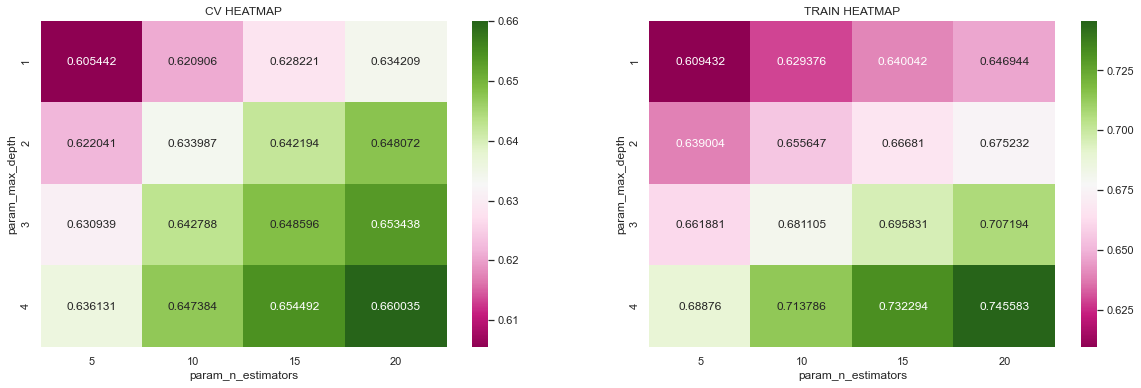

In [452]:
fig,ax=plt.subplots(1,2,figsize=(20,6))

sns.heatmap(max_score.mean_test_score,fmt='g',cmap='PiYG',ax=ax[0],annot=True)

sns.heatmap(max_score.mean_train_score,fmt='g',cmap='PiYG',ax=ax[1],annot=True)

ax[0].set_title('CV HEATMAP')
ax[1].set_title("TRAIN HEATMAP")
plt.show()

### Using best hyperparametrs set1

In [453]:
start=time.time()

tuned_gbdt=GradientBoostingClassifier(max_depth=4,n_estimators=20)
tuned_gbdt.fit(x_tr_set1,y_train)


end=time.time()
print((end-start))

26.641743659973145


###### Roc auc using predic proba

accuracy of the tuned model on train set is  0.8487142857142858
AUC score of the tuned model on train data is  0.7433115319550065
----------------------------------------
accuracy of the tuned model on test set is  0.8468333333333333
AUC score of the tuned model on test data is  0.6792878618344209


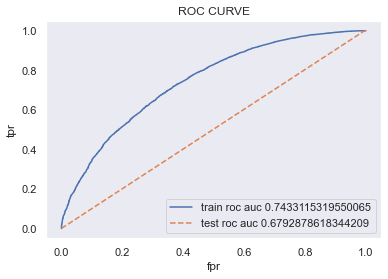

In [454]:
#train set
y_predtrain_tunedgbdt=tuned_gbdt.predict(x_tr_set1)
print('accuracy of the tuned model on train set is ',metrics.accuracy_score(y_train,y_predtrain_tunedgbdt))

proba_train=tuned_gbdt.predict_proba(x_tr_set1)
#keeping probs of the positive class only
proba_train = proba_train[:,1]

fpr_train,tpr_train,threshold_train=metrics.roc_curve(y_train,proba_train)
print('AUC score of the tuned model on train data is ',metrics.roc_auc_score(y_train,proba_train))
#print('MISC ',metrics.auc(x_tr_set1,y_train))
#plotting
plt.plot(fpr_train,tpr_train,linestyle='-',label='train roc auc '+str(metrics.roc_auc_score(y_train,proba_train)))

print("--"*20)
#test set
y_predtest_tunedgbdt = tuned_gbdt.predict(x_te_set1)
print('accuracy of the tuned model on test set is ',metrics.accuracy_score(y_test,y_predtest_tunedgbdt))

proba_test=tuned_gbdt.predict_proba(x_te_set1)
proba_test=proba_test[:,1]

fpr_test,tpr_test,threshold_test=metrics.roc_curve(y_test,y_predtest_tunedgbdt)
print('AUC score of the tuned model on test data is ',metrics.roc_auc_score(y_test,proba_test))
plt.plot(fpr_test,tpr_test,linestyle='--',label='test roc auc '+str(metrics.roc_auc_score(y_test,proba_test)))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC CURVE')
plt.grid()
plt.legend()
plt.show()


#### finding best threshold set1

In [455]:
def best_threshold(fpr,tpr,threshold):
    x=np.argmax(tpr*(1-fpr))
    return threshold[x]
   

def prd_on_best_threshold(threshold,y_pred_tuned_gbdt):
    pred=[]
    for y_hat in y_pred_tuned_gbdt:
        if y_hat > threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred
    
    

###### train  and test set best threshold and confusion matrix

In [456]:
#train set
best_threshold_train=best_threshold(fpr_train,tpr_train,threshold_train)
print('best threshold of train set is ',best_threshold_train)
#predmon best threshold
y_pred_train_best_threshold =  prd_on_best_threshold(best_threshold_train,y_predtrain_tunedgbdt)


#test set
best_threshold_test=best_threshold(fpr_test,tpr_test,threshold_test)
print('best threshold of test set is ',best_threshold_test)
#predmon best threshold
y_pred_test_best_threshold =  prd_on_best_threshold(best_threshold_test,y_predtest_tunedgbdt)


best threshold of train set is  0.8454436788244347
best threshold of test set is  1


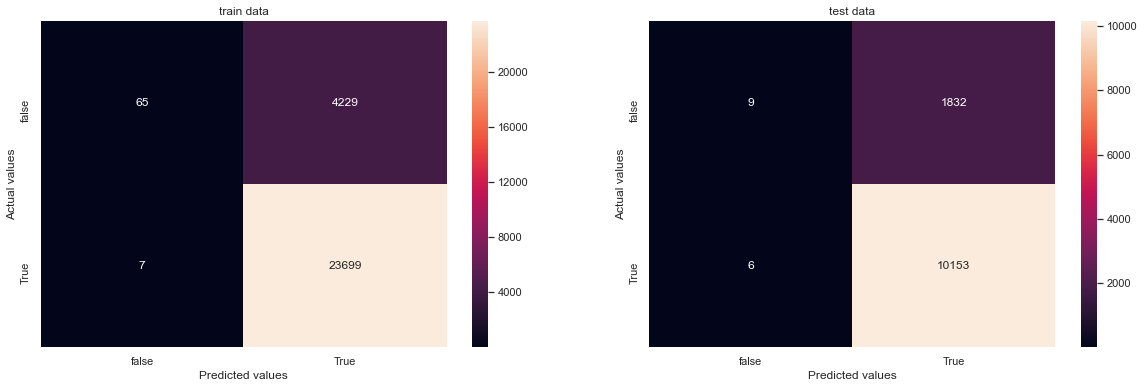

In [457]:
fig,ax=plt.subplots(1,2,figsize=(20,6))

#train set
cm_train=metrics.confusion_matrix(y_train,y_predtrain_tunedgbdt)
sns.heatmap(cm_train,annot=True,fmt='g',ax=ax[0])
ax[0].set_title('train data')
ax[0].set_xlabel('Predicted values')
ax[0].set_ylabel('Actual values')
ax[0].xaxis.set_ticklabels(['false','True'])
ax[0].yaxis.set_ticklabels(['false','True'])

#test set
cm_test=metrics.confusion_matrix(y_test,y_predtest_tunedgbdt)
sns.heatmap(cm_test,annot=True,fmt='g',ax=ax[1])
ax[1].set_title('test data')
ax[1].set_xlabel('Predicted values')
ax[1].set_ylabel('Actual values')
ax[1].xaxis.set_ticklabels(['false','True'])
ax[1].yaxis.set_ticklabels(['false','True'])

plt.show()



#  1.4.2 Stacking(SET 2)

Set 2: categorical(instead of one hot encoding, try response coding: use probability values), 
    numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)

In [458]:
x_tr_skul_state_rc.shape

(28000, 2)

In [459]:
tfidf_w2v_vector_train=sparse.csr_matrix(tfidf_w2v_vector_train)
tfidf_w2v_vectors_test=sparse.csr_matrix(tfidf_w2v_vectors_test)

In [460]:
x_tr_set2=hstack((tfidf_w2v_vector_train,x_tr_skul_state_rc,x_tr_prefix_rc,x_tr_prj_grade_cat_rc,x_tr_clean_cat_rc,
                 x_tr_subclean_cat_rc,x_tr_price_norm,x_tr_prevposted_norm,x_tr_positive_norm,x_tr_negative_norm,
                 x_tr_neutral_norm,x_tr_compound_norm)).tocsr()

x_te_set2=hstack((tfidf_w2v_vectors_test,x_te_skul_state_rc,x_te_prefix_rc,x_te_prj_grade_cat_rc,x_te_clean_cat_rc,
                 x_te_subclean_cat_rc,x_te_price_norm,x_te_prevposted_norm,x_te_positive_norm,x_te_negative_norm,
                 x_te_neutral_norm,x_te_compound_norm)).tocsr()

print(x_tr_set2.shape)
print(x_te_set2.shape)

(28000, 316)
(12000, 316)


### Applying gbdt

In [461]:
gbdt=GradientBoostingClassifier()
gbdt.fit(x_tr_set2,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [462]:
y_pred_gbdt = gbdt.predict(x_te_set2)

In [463]:
gbdt_accuracy=metrics.accuracy_score(y_test,y_pred_gbdt)
print('accuracy of gbdt without any tuning is = ',gbdt_accuracy)

accuracy of gbdt without any tuning is =  0.8453333333333334


### Hyper parameter tuning

In [464]:
pm={"max_depth":[1,2,3,4],"n_estimators":[5,10,15,20]}

In [465]:
start=time.time()
clf = GridSearchCV(gbdt,param_grid=pm,scoring='roc_auc',return_train_score=True,n_jobs=-1,cv=10,verbose=1)
clf.fit(x_tr_set2,y_train)
end=time.time()
print('time taken ',end-start)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 22.5min finished


time taken  1436.3896281719208


In [466]:
print('Best parameters are ',clf.best_params_ )
print('Best roc auc score is ',clf.best_score_ )

Best parameters are  {'max_depth': 4, 'n_estimators': 20}
Best roc auc score is  0.684199398759257


### Heatmap

In [467]:
df=pd.DataFrame(clf.cv_results_,columns=clf.cv_results_.keys())
max_score=df.groupby(['param_max_depth','param_n_estimators']).max()
max_score=max_score.unstack()[['mean_train_score','mean_test_score']]

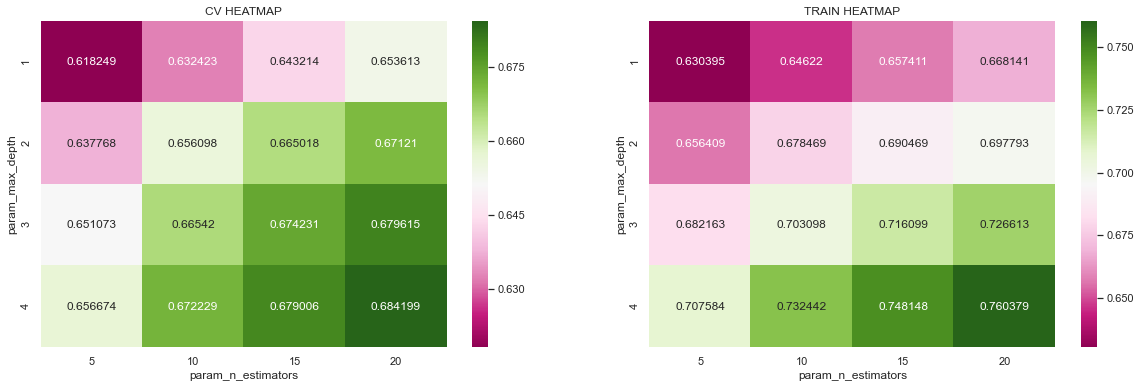

In [468]:
fig,ax=plt.subplots(1,2,figsize=(20,6))

sns.heatmap(max_score.mean_test_score,fmt='g',cmap='PiYG',ax=ax[0],annot=True)

sns.heatmap(max_score.mean_train_score,fmt='g',cmap='PiYG',ax=ax[1],annot=True)

ax[0].set_title('CV HEATMAP')
ax[1].set_title("TRAIN HEATMAP")
plt.show()

### Using best hyperparametrs set2

In [469]:
start=time.time()

tuned_gbdt=GradientBoostingClassifier(max_depth=4,n_estimators=20)
tuned_gbdt.fit(x_tr_set2,y_train)


end=time.time()
print((end-start))

81.9489495754242


###### Roc auc using predic proba

accuracy of the tuned model on train set is  0.8473928571428572
AUC score of the tuned model on train data is  0.756936352086071
accuracy of the tuned model on test set is  0.84625
AUC score of the tuned model on test data is  0.6762041390880118


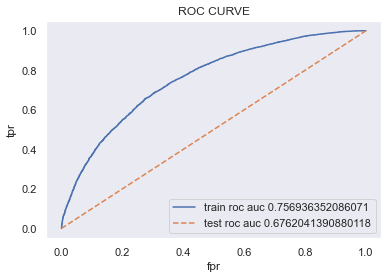

In [470]:
#train set
y_predtrain_tunedgbdt=tuned_gbdt.predict(x_tr_set2)
print('accuracy of the tuned model on train set is ',metrics.accuracy_score(y_train,y_predtrain_tunedgbdt))

proba_train=tuned_gbdt.predict_proba(x_tr_set2)
#keeping probs of the positive class only
proba_train = proba_train[:,1]

fpr_train,tpr_train,threshold_train=metrics.roc_curve(y_train,proba_train)
print('AUC score of the tuned model on train data is ',metrics.roc_auc_score(y_train,proba_train))
#plotting
plt.plot(fpr_train,tpr_train,linestyle='-',label='train roc auc '+str(metrics.roc_auc_score(y_train,proba_train)))


#test set
y_predtest_tunedgbdt = tuned_gbdt.predict(x_te_set2)
print('accuracy of the tuned model on test set is ',metrics.accuracy_score(y_test,y_predtest_tunedgbdt))

proba_test=tuned_gbdt.predict_proba(x_te_set2)
proba_test=proba_test[:,1]

fpr_test,tpr_test,threshold_test=metrics.roc_curve(y_test,y_predtest_tunedgbdt)
print('AUC score of the tuned model on test data is ',metrics.roc_auc_score(y_test,proba_test))
plt.plot(fpr_test,tpr_test,linestyle='--',label='test roc auc '+str(metrics.roc_auc_score(y_test,proba_test)))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.grid()
plt.title('ROC CURVE') 
plt.legend()
plt.show()


###### train  and test set best threshold and confusion matrix

In [471]:
#train set
best_threshold_train=best_threshold(fpr_train,tpr_train,threshold_train)
print('best threshold of train set is ',best_threshold_train)
#predmon best threshold
y_pred_train_best_threshold =  prd_on_best_threshold(best_threshold_train,y_predtrain_tunedgbdt)


#test set
best_threshold_test=best_threshold(fpr_test,tpr_test,threshold_test)
print('best threshold of test set is ',best_threshold_test)
#predmon best threshold
y_pred_test_best_threshold =  prd_on_best_threshold(best_threshold_test,y_predtest_tunedgbdt)


best threshold of train set is  0.8419469139136653
best threshold of test set is  2


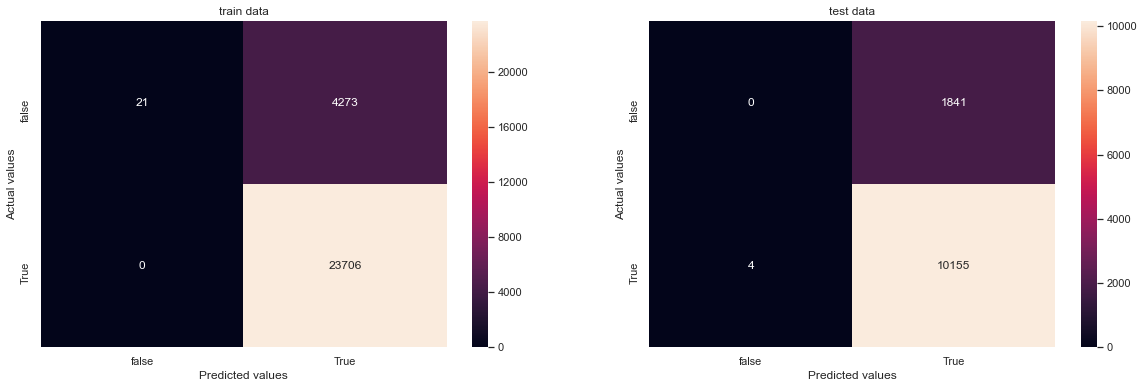

In [472]:
fig,ax=plt.subplots(1,2,figsize=(20,6))

#train set
cm_train=metrics.confusion_matrix(y_train,y_predtrain_tunedgbdt)
sns.heatmap(cm_train,annot=True,fmt='g',ax=ax[0])
ax[0].set_title('train data')
ax[0].set_xlabel('Predicted values')
ax[0].set_ylabel('Actual values')
ax[0].xaxis.set_ticklabels(['false','True'])
ax[0].yaxis.set_ticklabels(['false','True'])

#test set
cm_test=metrics.confusion_matrix(y_test,y_predtest_tunedgbdt)
sns.heatmap(cm_test,annot=True,fmt='g',ax=ax[1])
ax[1].set_title('test data')
ax[1].set_xlabel('Predicted values')
ax[1].set_ylabel('Actual values')
ax[1].xaxis.set_ticklabels(['false','True'])
ax[1].yaxis.set_ticklabels(['false','True'])

plt.show()



In [473]:
from prettytable import PrettyTable

In [475]:
table=PrettyTable()
table.field_names =['Vectorizer','Model','Hyper parameter','TEST AUC']
table.add_row(['TFIDF','GBDT','max_depth=4, n_estimators=20 ',' 0.6792'])
table.add_row(['TFIDF W2VEC','GBDT','max_depth=4, n_estimators=20 ','0.6762'])
print(table)


+-------------+-------+-------------------------------+----------+
|  Vectorizer | Model |        Hyper parameter        | TEST AUC |
+-------------+-------+-------------------------------+----------+
|    TFIDF    |  GBDT | max_depth=4, n_estimators=20  |  0.6792  |
| TFIDF W2VEC |  GBDT | max_depth=4, n_estimators=20  |  0.6762  |
+-------------+-------+-------------------------------+----------+
